In [4]:
import pyart
import numpy as np
import cartopy
import shapely
import geopandas as gpd
import struct
import proplot as plot

In [35]:
fn = '/g/data1a/kl02/jb2354/UQXPOL/0021_20171231_024600_08_02.scn'
with open(fn, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

# radar position
latr, lonr =  -28.333933, 151.088720
rpoint = shapely.geometry.Point((lonr,latr))
aeqd = cartopy.crs.AzimuthalEquidistant(central_longitude=lonr, central_latitude=latr)

In [36]:
progress = struct.unpack('H',fileContent[:2])[0]
header_info  = struct.unpack('=HHHHHHHHhHHhHHHHHHHhhHHHlhlhHHHHHHHHHH',fileContent[:progress])
lat = header_info[8] - header_info[9]/60 - header_info[10]/(1e3*(60**2))
lon = header_info[11] + header_info[12]/60 + header_info[13]/(1e3*(60**2))
nrays, ngates = header_info[21],header_info[22]
dr = header_info[23]/100
nfields = 9
sf = np.array([[1, 32768,100,0]]*5 + [[360,32768,65535,0]] + [[2,1,65534,0]] + [[1,1,100,0]] + [[1,0,1,-1]])

out, az, el = [], [], []
for i in range(nrays):
    antenna_info = struct.unpack('=HHhH',fileContent[progress:progress+2*4])
    az.append(antenna_info[1]/100)
    el.append(antenna_info[2]/100)

    progress += 2*4
    
    tgates = ngates * nfields
    raw_data = struct.unpack('='+'H'*tgates,fileContent[progress:progress+2*tgates])
    out.append(np.array(raw_data).reshape(ngates, nfields, order = 'F'))
    progress += 2*tgates

out, az, el = np.array(out), np.array(az), np.array(el)

data = np.ma.masked_array(out.copy())
for i in range(nfields):  
    data[...,i] = sf[i,0] * (np.ma.masked_equal(data[...,i],sf[i,3])-sf[i,1]) / sf[i,2] 

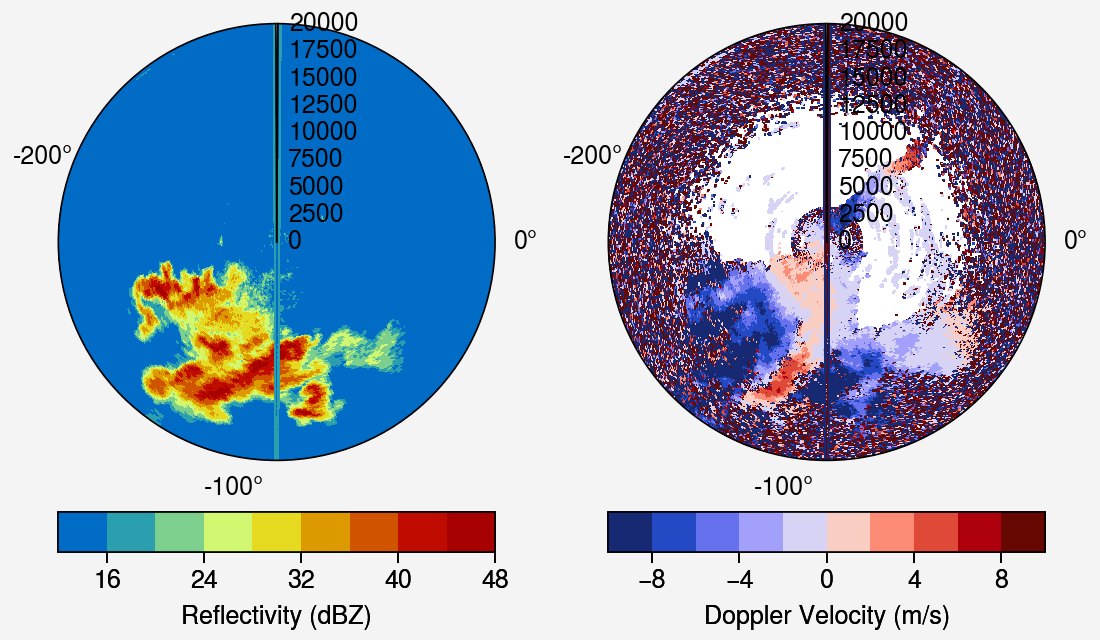

In [37]:
kwargs = dict(cmap = 'pyart_homeyerrainbow',  vmin=10, vmax= 50, colorbar_kw={'label':'Reflectivity (dBZ)'})
kwargs2 = dict(cmap = 'BR', vmin = -10, vmax= 10, colorbar_kw={'label':'Doppler Velocity (m/s)'})

fig, axs = plot.subplots(width=  5.5, ncols = 2, proj = 'polar')

mask = data[...,1] < -20

axs[0].pcolormesh(np.radians(90-az), dr*np.arange(ngates),np.ma.masked_array(data[...,1],mask).T, colorbar = 'b', **kwargs)
axs[1].pcolormesh(np.radians(90-az), dr*np.arange(ngates),np.ma.masked_array(data[...,2],mask).T, colorbar = 'b', **kwargs2)

axs.format(thetalim =[90-np.amin(az),90-np.amax(az)], rlim = [0, 20000])
fig.save('/home/564/jb2354/dev/UQ/decoding_example_old.png', dpi = 200)
plot.show()

In [38]:
lat, lon

(-28.333, 151.089)